In [93]:
# simulating amm in with different fee amounts
from functools import total_ordering
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt


In [94]:
def pretty_print_table(df):
    formatted_df = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for col in formatted_df.select_dtypes(include=['float', 'int']).columns:
        formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:,.4f}")
    print(formatted_df)

In [95]:
moe_asset = "USD"

time_interval = "1min"  # Choose from "1min", "5min", "30min", "daily"
asset_list = ["EUR"]


total_pool = 600262.78
specified_weights = {"EUR": 0.5}

In [96]:
"""

1min = 2m
5min = 3m
10min = 3m
30min = 1y
1h = 1y
daily = 20y

c = 1.05, 1.25, 1.5
order_size = 100, 1'000, 10'000
fees = ?

"""

"\n\n1min = 2m\n5min = 3m\n10min = 3m\n30min = 1y\n1h = 1y\ndaily = 20y\n\nc = 1.05, 1.25, 1.5\norder_size = 100, 1'000, 10'000\nfees = ?\n\n"

In [97]:
time_col = "Local Time"
time_period_price_col = "Open"

# Define date ranges for each time interval
date_ranges = {
    "1min": ("22sep", "22dec"),
    "5min": ("22sep", "22dec"),
    "30min": ("22dec2023", "22dec"),
    "daily": ("22dec2004", "22dec"),
}

# Base directory for the historical data files
base_dir = "hist_bidask"

# Validate time interval and get the date range
if time_interval not in date_ranges:
    raise ValueError(f"Invalid time interval: {time_interval}. Choose from {list(date_ranges.keys())}.")

start_date, end_date = date_ranges[time_interval]

# Create a function to construct file paths dynamically
def get_file_path(asset, interval):
    return f"{base_dir}/{asset}_{start_date}_{end_date}_{interval}.xlsx"

# Load data for each asset
asset_data = {}
for asset in asset_list:
    file_path = get_file_path(asset, time_interval)
    print(f"Loading data from: {file_path}")  # Debug: Show the file path
    # Load the data
    data = pd.read_excel(file_path)

    # Drop unnecessary columns if they exist
    columns_to_drop = ["Local Date", "Refresh Rate", "BidNet"]
    data = data.drop(columns=[col for col in columns_to_drop if col in data.columns], errors="ignore")
    
    # Sort by date in ascending order and reset the index
    data = data.sort_values(by=time_col, ascending=True).reset_index(drop=True)

    # Handle special case for CHF (invert exchange rates)
    #if asset in ["CHF", "CAD", "JPY"]: # 1 currency buys x of usd
    if asset in ["AUD", "NZD", "EUR", "GBP"]: # 1 USD buys x of currency
        for col in ["Bid", "Ask", "High", "Low", "Open"]:
            if col in data.columns:
                data[col] = 1 / data[col]
    
    # Store the processed data
    asset_data[asset] = data
    
    # Debug: Verify the sorted data
    print(f"Asset: {asset}")
    print(asset_data[asset])  # Show the first few rows

# Example: Access EUR data
# eur_data = asset_data["EUR"]
# print(eur_data.head())  # Verify the loaded data

Loading data from: hist_bidask/EUR_22sep_22dec_1min.xlsx
Asset: EUR
               Local Time       Bid       Ask      High       Low      Open
0     2024-09-22 23:35:00  0.895977  0.895736  0.895977  0.895977  0.895977
1     2024-09-22 23:51:00  0.895736  0.895415  0.895736  0.895736  0.895736
2     2024-09-23 00:17:00  0.895817  0.895576  0.895817  0.895817  0.895817
3     2024-09-23 00:19:00  0.895897  0.895656  0.895817  0.895897  0.895817
4     2024-09-23 00:20:00  0.895897  0.895656  0.895817  0.895897  0.895817
...                   ...       ...       ...       ...       ...       ...
92976 2024-12-20 23:56:00  0.959049  0.958865  0.958957  0.959049  0.958957
92977 2024-12-20 23:57:00  0.959049  0.958957  0.958957  0.959141  0.958957
92978 2024-12-20 23:58:00  0.958957  0.958865  0.958957  0.959049  0.959049
92979 2024-12-20 23:59:00  0.958957  0.958773  0.958865  0.959141  0.959049
92980 2024-12-21 00:00:00  0.958865  0.958681  0.958865  0.958957  0.958957

[92981 rows x 6 col

In [98]:
# Merge unique timestamps from both datasets and sort them
#unique_times = pd.concat([aapl_data['Time'], msft_data['Time']]).drop_duplicates().sort_values()
# Extract unique times from all assets dynamically
unique_times = pd.concat([data[time_col] for data in asset_data.values()]).drop_duplicates().sort_values().reset_index(drop=True)

# Print the sorted unique times for verification
print("Unique Times:")
print(unique_times)
#with pd.option_context('display.max_rows', None):   print(unique_times)

Unique Times:
0       2024-09-22 23:35:00
1       2024-09-22 23:51:00
2       2024-09-23 00:17:00
3       2024-09-23 00:19:00
4       2024-09-23 00:20:00
                ...        
92976   2024-12-20 23:56:00
92977   2024-12-20 23:57:00
92978   2024-12-20 23:58:00
92979   2024-12-20 23:59:00
92980   2024-12-21 00:00:00
Name: Local Time, Length: 92981, dtype: datetime64[ns]


In [99]:
def find_indexes_by_dates(df, start_date, end_date):
    # Convert the input dates to datetime
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    # Find the start index (earliest time not earlier than the start date)
    start_index = df.searchsorted(start_date, side='left')
    # Find the end index (latest time not exceeding the end date)
    end_index = df.searchsorted(end_date, side='right') - 1
    
    # Ensure the indexes are within valid range
    if start_index >= len(df):
        raise ValueError(f"Start date {start_date} is beyond the available data range.")
    if end_index < 0:
        raise ValueError(f"End date {end_date} is earlier than the available data range.")
    
    # Extract neighborhood entries
    start_neighbors = df[max(start_index - 2, 0): start_index + 3]
    end_neighbors = df[max(end_index - 2, 0): end_index + 3]
    
    # Return the indexes and neighborhood entries
    return start_index, end_index, start_neighbors, end_neighbors

# Example usage
start_date = "2024-10-01 00:00:00"
end_date = "2024-12-01 00:00:00"
start_idx, end_idx, start_neighbors, end_neighbors = find_indexes_by_dates(unique_times, start_date, end_date)

# Print results
print(f"Start index: {start_idx}, corresponding time: {unique_times.iloc[start_idx]}")
print(f"Start neighbors:\n{start_neighbors}")
print(f"End index: {end_idx}, corresponding time: {unique_times.iloc[end_idx]}")
print(f"End neighbors:\n{end_neighbors}")


Start index: 8453, corresponding time: 2024-10-01 00:00:00
Start neighbors:
8451   2024-09-30 23:58:00
8452   2024-09-30 23:59:00
8453   2024-10-01 00:00:00
8454   2024-10-01 00:01:00
8455   2024-10-01 00:02:00
Name: Local Time, dtype: datetime64[ns]
End index: 71392, corresponding time: 2024-11-30 00:00:00
End neighbors:
71390   2024-11-29 23:58:00
71391   2024-11-29 23:59:00
71392   2024-11-30 00:00:00
71393   2024-12-01 20:17:00
71394   2024-12-01 20:22:00
Name: Local Time, dtype: datetime64[ns]


In [100]:
manual_index = False

if manual_index:
    print("Manual indexing is enabled.")
    # Define manual start and end indices (default 0 for full range)
    manual_start_index = 42021  # Set to desired index, e.g., 4
    manual_end_index = 72594  # Set to desired index, e.g., 10

    # Print the corresponding times for manual indices
    print(f"Manual start index: {manual_start_index}, corresponding time: {unique_times.iloc[manual_start_index]}")
    print(f"Manual end index: {manual_end_index}, corresponding time: {unique_times.iloc[manual_end_index]}")
else:
    print("Automatic indexing is enabled.")
    # Find the start and end indices automatically
    start_index = unique_times[unique_times >= start_date].index[0]
    end_index = unique_times[unique_times <= end_date].index[-1]

    # Print results
    print(f"Automatic start index: {start_index}, corresponding time: {unique_times.iloc[start_index]}")
    print(f"Automatic end index: {end_index}, corresponding time: {unique_times.iloc[end_index]}")

    # Optionally, use these indices for further analysis
    manual_start_index = start_index
    manual_end_index = end_index
print()

# Validate and adjust the indices if out of range
if manual_start_index < 0 or manual_start_index >= len(unique_times):
    manual_start_index = 0
if manual_end_index < 0 or manual_end_index >= len(unique_times):
    manual_end_index = len(unique_times) - 1

# Get the corresponding times for the selected indices
period_start = unique_times.iloc[manual_start_index]
period_end = unique_times.iloc[manual_end_index]

# Filter unique times within the selected range
filtered_times = unique_times.iloc[manual_start_index:manual_end_index + 1].reset_index(drop=True)

# Print the selected period and filtered times for verification
print(f"Simulation Period: {period_start} to {period_end}")
print(filtered_times)

# Temporarily set pandas options to display all rows
#with pd.option_context('display.max_rows', None):   print(filtered_times)

Automatic indexing is enabled.
Automatic start index: 8453, corresponding time: 2024-10-01 00:00:00
Automatic end index: 71392, corresponding time: 2024-11-30 00:00:00

Simulation Period: 2024-10-01 00:00:00 to 2024-11-30 00:00:00
0       2024-10-01 00:00:00
1       2024-10-01 00:01:00
2       2024-10-01 00:02:00
3       2024-10-01 00:04:00
4       2024-10-01 00:05:00
                ...        
62935   2024-11-29 23:56:00
62936   2024-11-29 23:57:00
62937   2024-11-29 23:58:00
62938   2024-11-29 23:59:00
62939   2024-11-30 00:00:00
Name: Local Time, Length: 62940, dtype: datetime64[ns]


In [101]:
# data = {"EUR": eur_data} 
# print(data)

print("Used DataFrames for Simulation:")

filtered_asset_data = {}
for asset in asset_list:
    # Get the original data frame for the asset
    df = asset_data[asset]
    
    # Filter rows where the time column matches the filtered times
    filtered_df = df[df[time_col].isin(filtered_times)].reset_index(drop=True)
    filtered_asset_data[asset] = filtered_df
    
    # Print the asset name and the filtered data
    print(f"Asset: {asset}")
    #with pd.option_context('display.max_rows', None):   print(filtered_df)
    print(filtered_df)
    print()  # Add space between assets for clarity

Used DataFrames for Simulation:
Asset: EUR
               Local Time       Bid       Ask      High       Low      Open
0     2024-10-01 00:00:00  0.898150  0.898069  0.898069  0.898150  0.898069
1     2024-10-01 00:01:00  0.898634  0.898473  0.898150  0.898634  0.898150
2     2024-10-01 00:02:00  0.898553  0.898392  0.898553  0.898553  0.898553
3     2024-10-01 00:04:00  0.898473  0.898150  0.898473  0.898473  0.898473
4     2024-10-01 00:05:00  0.898311  0.898069  0.898311  0.898473  0.898473
...                   ...       ...       ...       ...       ...       ...
62935 2024-11-29 23:56:00  0.945537  0.945269  0.945358  0.945537  0.945448
62936 2024-11-29 23:57:00  0.945448  0.945269  0.945448  0.945537  0.945537
62937 2024-11-29 23:58:00  0.945448  0.945269  0.945448  0.945448  0.945448
62938 2024-11-29 23:59:00  0.945448  0.945269  0.945448  0.945448  0.945448
62939 2024-11-30 00:00:00  0.945626  0.945358  0.945448  0.945626  0.945448

[62940 rows x 6 columns]



In [102]:
usd_weight = 1 - sum(specified_weights.values())

# Check if USD weight is valid
if usd_weight <= 0:
    raise ValueError(
        f"Invalid weights: the specified weights ({sum(specified_weights.values())}) "
        f"exceed or equal 1, leaving no positive weight for USD."
    )

# Add USD to the list of assets and its weight to the weights dictionary
assets = [moe_asset] + asset_list
weights = {moe_asset: usd_weight, **specified_weights}

# Verify weights sum to 1 (debugging and validation)
if abs(sum(weights.values()) - 1) > 1e-9:
    raise ValueError(
        f"Weights do not sum to 1. Current total: {sum(weights.values())}."
    )

# Fetch spot prices for each asset
# USD is always 1 (medium of exchange), others fetch dynamically
'''spot_prices = {
    moe_asset: 1,  # USD as the medium of exchange
    "EUR": eur_data.iloc[0][time_period_price_col],
}'''
# Dynamically fetch spot prices for each asset
spot_prices = {}
for asset in assets:
    if asset == moe_asset:
        # Medium of exchange has a fixed spot price of 1
        spot_prices[asset] = 1
    else:
        # Fetch the spot price from the first entry of the corresponding filtered data frame
        spot_prices[asset] = filtered_asset_data[asset].iloc[0][time_period_price_col]


starting_table = pd.DataFrame({
    "asset": assets,
    "weight": [weights[asset] for asset in assets],
    "spot": [spot_prices.get(asset, 1) for asset in assets],
})

starting_table["value"] = total_pool * starting_table["weight"]
starting_table["balance"] = starting_table["value"] * starting_table["spot"]

starting_table.set_index("asset", inplace=True)

pretty_print_table(starting_table)

       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  300,131.3900  300,131.3900
EUR    0.5000  0.8981  300,131.3900  269,538.7427


In [103]:
# Fee values for different scenarios
#fee_values = [0.1, 0.25, 0.3, 0.4, 0.5, 0.75, 0.9, 1, 1.25, 1.5, 2, 2.5]
#fee_values = [0.01, 0.1, 0.5, 1]
#order_sizes = [1, 10, 100, 1000]
fee_values = [0.1, 0.5, 1, 1.5, 2]
order_sizes = [100, 1000, 10000]

base_asset = starting_table.index[0]
if True:
  print(f"Base asset: {base_asset}")

  for asset in starting_table.index:
    print(asset)

Base asset: USD
USD
EUR


In [104]:
#Calculate invariant based on balances and weights.
def calculate_invariant(inv_table):
    #inv = 1
    #for asset in assets:
    #    inv *= balances[asset] ** weights[asset]
    #for asset in assets_table.items():
        #inv *= asset["balance"] ** asset["weight"]
    #return inv
    return (inv_table["balance"] ** inv_table["weight"]).prod()

In [105]:
def print_pool_standing(info_table):
    #pd.DataFrame(info_table)
    print(f"Assets: {info_table.index}")
    #print(f"Weights: {weights}")
    print(f"Balances: {info_table["balance"]}")
    print(f"Inv: {calculate_invariant(info_table)}")
    #print("Values: ")
    total_pool_value = 0
    #for asset in assets:
        #total_pool_value += balances[asset] * opens[asset]
        #print("Asset ", asset, " value: ", balances[asset] * opens[asset])
        #inv *= balances[asset] ** weights[asset])
    print(f"Total pool value: {info_table["value"].sum()}")

In [111]:
historical_values_df = {}
daily_pool_values = {}  # Dictionary to store USD values for each date

hist_hold_table = starting_table.copy()
print(hist_hold_table)
# Append the new variation's data to the DataFrame
if 'historical_values_df' not in globals():
    # Initialize DataFrame if it doesn't exist
    historical_values_df = pd.DataFrame()

# Get the first date in filtered_times
first_date = pd.to_datetime(filtered_times.iloc[0]).date()

# Calculate the previous date
before_start_date = first_date - pd.Timedelta(days=1)

# Append the previous date with a value of 0 to daily_pool_values
daily_pool_values[before_start_date] = 0
print(f"Appended initial value for {before_start_date}: {daily_pool_values}")

for time_index, time in enumerate(filtered_times):
    current_date = time.date()  # Extract the current date from the timestamp
    next_date = filtered_times[time_index + 1].date() if time_index + 1 < len(filtered_times) else None

    if current_date != next_date:  # The day is rolling over
        for asset in hist_hold_table.index:
            if asset == base_asset:
                #open_prices[asset] = spots["USD"]
                #last_close_prices[asset] = spots["USD"]
                pass
            else:
                asset_df = asset_data[asset]
                row = asset_df[asset_df[time_col] == time]
                hist_hold_table.at[asset, "spot"] = row["Open"].values[0]
            hist_hold_table.at[asset, "value"] = hist_hold_table.at[asset, "balance"] / hist_hold_table.at[asset, "spot"]
    
        #pool_value = hist_hold_table["value"].sum() - total_pool  # Calculate total value of the pool in USD
        #daily_pool_values[current_date] = pool_value  # Append the value for the day
        daily_pool_values[current_date] = hist_hold_table["value"].sum() - total_pool
        #print(f"Appended return for {current_date}: {pool_value}")


# Ensure the last day is recorded
if current_date not in daily_pool_values:
    daily_pool_values[current_date] = hist_hold_table["value"].sum() - total_pool

historical_values_df["hold"] = pd.Series(daily_pool_values)
print(historical_values_df)

       weight      spot      value        balance
asset                                            
USD       0.5  1.000000  300131.39  300131.390000
EUR       0.5  0.898069  300131.39  269538.742703
Appended initial value for 2024-09-30: {datetime.date(2024, 9, 30): 0}
{'hold': 2024-09-30        0.000000
2024-10-01    -1832.863450
2024-10-02    -2452.802559
2024-10-03    -2857.110673
2024-10-04    -4312.619883
2024-10-05    -4366.527632
2024-10-06    -4393.481506
2024-10-07    -4339.573758
2024-10-08    -4177.850512
2024-10-09    -5256.005483
2024-10-10    -5336.867106
2024-10-11    -5363.820980
2024-10-12    -5390.774854
2024-10-13    -5498.590351
2024-10-14    -6118.529459
2024-10-15    -6576.745322
2024-10-16    -7358.407676
2024-10-17    -8193.977778
2024-10-18    -7223.638304
2024-10-19    -7250.592179
2024-10-20    -7385.361550
2024-10-21    -8652.193641
2024-10-22    -9083.455629
2024-10-23    -9514.717617
2024-10-24    -8274.839401
2024-10-25    -9164.317252
2024-10-26    -919

In [110]:
results = []
result_tables = []
direction = {}

# last_date = None  # To track the last recorded date

#sim_table = starting_table
for order_size in order_sizes:
    print(f"Order Size simulation: {order_size}")
    # Loop through each fee variation
    for fee_percentage in fee_values:
        print(f"Fee % simulation: {fee_percentage}")
        sim_table = starting_table.copy()
        trades = 0
        fees_earned = 0
        fee = fee_percentage / 100
        # Initialize balances and invariant
        #balances = {asset: (initial_pool * weights[asset]) / spots[asset] for asset in assets}


        trades_log = []
        end_of_period_values = []

        # Loop through each unique time period
        # Fetch data for each asset at the current time and update last close prices if needed
        open_prices = {}
        last_close_prices = {}
        #open_prices[asset] = spots["USD"]
        #last_close_prices[asset] = spots["USD"]
        times = 0
        missing_data_log = {}
        
        daily_pool_values[before_start_date] = 0
        print(f"Appended initial value for {before_start_date}: {daily_pool_values[before_start_date]}")

        for time_index, time in enumerate(filtered_times):
            current_date = time.date()  # Extract the current date from the timestamp
            next_date = filtered_times[time_index + 1].date() if time_index + 1 < len(filtered_times) else None

            '''times += 1
            if times > 2:
                break'''
            #if trades > 10:
                #rint("breaking")
                #break

            if False:
                print(time)
                if False:
                    print(sim_table)
            if False:
                print("Current date: ", current_date)
                print("Next date: ", next_date)
            missing_data_assets = set()
            #
            for asset in sim_table.index:
                if asset == base_asset:
                    #open_prices[asset] = spots["USD"]
                    #last_close_prices[asset] = spots["USD"]
                    pass
                else:
                    direction[asset] = None
                    #asset_data = data[asset]
                    #row = asset_data[asset_data[time_col] == time]
                    asset_df = asset_data[asset]
                    row = asset_df[asset_df[time_col] == time]
                    if row.empty:
                        if False:
                            print(f"No data for asset {asset} at time {time}")
                        missing_data_assets.add(asset)  # Flag the asse
                        # Log the missing data for later analysis
                        if time not in missing_data_log:
                            missing_data_log[time] = []
                        missing_data_log[time].append(asset)
                        continue
                    else:
                        #sim_table.at[asset, "spot"] = row[time_period_price_col].values[0]
                        sim_table.at[asset, "spot"] = row["Open"].values[0]
                        sim_table.at[asset, "value"] = sim_table.at[asset, "balance"] / sim_table.at[asset, "spot"]

                        # Define `market_bid` and `market_ask` once for the current time and asset
                        market_bid = row['Bid'].values[0]
                        market_ask = row['Ask'].values[0]
                        
                        sim_table.at[asset, "market_bid"] = market_bid  # Optional: Store for later use
                        sim_table.at[asset, "market_ask"] = market_ask  # Optional: Store for later use

                        if False:
                            print(f"Asset: {asset}")
                            print(row)
                            
                            print(f"1 {moe_asset} (MOE) = bid: {market_bid}, ask: {market_ask}")
                            #print(f"Market bid: {1 / market_bid}, Market ask: {1 / market_ask} (in terms of MOE)")
                    '''if not row.empty:
                        sim_table.at[asset, "spot"] = row['Open'].values[0]
                        last_close_prices[asset] = row['Close'].values[0]
                    else:
                        open_prices[asset] = sim_table.at[asset, "spot"]'''
                        

            # Trading loop for each asset
            continue_trading = True
            while continue_trading:
                continue_trading = False

                for asset in sim_table.index:
                    if asset == base_asset or asset in missing_data_assets:  # Skip flagged assets for this time
                        continue

                    #print(asset)
                    market_bid = sim_table.at[asset, "market_bid"]
                    market_ask = sim_table.at[asset, "market_ask"]

                    '''
                    # Fetch high and low prices for the asset
                    row = asset_df[asset][asset_df[asset][time_col] == time]
                    if not row.empty:
                        #high_price = row['High'].values[0]
                        #low_price = row['Low'].values[0]
                        market_bid = row['Bid'].values[0]
                        market_ask = row['Ask'].values[0]

                        # Calculate bid and ask prices for the current asset
                        other_balances_product = 1
                        for other_asset in assets:
                            if other_asset != asset and other_asset != "USD":
                                #print("other asset: ", other_asset, " balance: ", balances[other_asset], " weight: ", weights[other_asset])
                                other_balances_product *= balances[other_asset] ** weights[other_asset]

                        inv = calculate_invariant(balances, weights)'''
                    #inv = calculate_invariant(sim_table)
                    balance = sim_table.at[asset, "balance"]
                    weight = sim_table.at[asset, "weight"]

                    moe_balance = sim_table.at[base_asset, "balance"]
                    moe_weight = sim_table.at[base_asset, "weight"]
                    
                    if False:
                        print(f"Balance: {balance}, weight: {weight}")
                        other_balances_product = inv / (balance ** weight)
                        print(f"Inv: {inv}, Other bal product: {other_balances_product}")
                    #print("other asset balances produt: ", other_balances_product)
                    #print("balance of the asset: ", balances[asset])
                    #print("invariant: ", balances[asset]**weights[asset] * other_balances_product)

                    #bid_amount_wo_fee = abs(((inv / ((balance + order_size) ** weight * other_balances_product)) ** (1 / sim_table.at["USD", "weight"]) - sim_table.at["USD", "balance"]))
                    #ask_amount_wo_fee = abs(((inv / ((balance - order_size) ** weight * other_balances_product)) ** (1 / sim_table.at["USD", "weight"]) - sim_table.at["USD", "balance"]))

                    #bid_amount_wo_fee = sim_table.at["USD", "balance"] - (((sim_table.at["USD", "balance"]**sim_table.at["USD", "weight"] * balance**weight) / ((balance + order_size)**weight)))**(1 / sim_table.at["USD", "weight"])
                    #ask_amount_wo_fee = -sim_table.at["USD", "balance"] + (((sim_table.at["USD", "balance"]**sim_table.at["USD", "weight"] * balance**weight) / ((balance - order_size)**weight)))**(1 / sim_table.at["USD", "weight"])
                    

                    #bid_amount_wo_fee = moe_balance - (((moe_balance**moe_weight * balance**weight) / ((balance + order_size)**weight)))**(1 / moe_weight)
                    #ask_amount_wo_fee = -moe_balance+ (((moe_balance**moe_weight * balance**weight) / ((balance - order_size)**weight)))**(1 / moe_weight)

                    bid_amount_wo_fee = balance - (((moe_balance**moe_weight * balance**weight) / ((moe_balance + order_size)**moe_weight)))**(1 / weight)
                    ask_amount_wo_fee = -balance+ (((moe_balance**moe_weight * balance**weight) / ((moe_balance - order_size)**moe_weight)))**(1 / weight)

                    if False:
                        print(f"1 {moe_asset} (MOE) = bid: {market_bid}, ask: {market_ask}")
                        print(asset, " bid (wo fee): ", bid_amount_wo_fee)
                        print(asset, " ask (wo fee): ", ask_amount_wo_fee)
                    
                    bid_amount = bid_amount_wo_fee * (1 - fee)
                    ask_amount = ask_amount_wo_fee * (1 + fee)

                    bid_price = bid_amount / order_size
                    ask_price = ask_amount / order_size

                    if False:
                        print(asset, " bid: ", bid_price)
                        print(asset, " ask: ", ask_price)

                    # Sell asset
                    if market_bid > ask_price and direction[asset] != "buy":
                        if balance >= order_size:
                            direction[asset] = "sell"
                            trades += 1
                            if False:
                                print("Trade: ", trades)
                                pretty_print_table(sim_table)
                                #trades_log.append({'Time': time, 'Asset': asset, 'Action': 'Sell', 'Shares': 1, 'Price': ask_price})
                                #print({'Time': time, 'Asset': asset, 'Action': 'Sell', 'Shares': 1, 'Price': ask_price})
                                #trade_printout = {'Time': time, 'Asset': asset, 'Action': 'Sell', 'Quantity': order_size, 'Amount': round(float(ask_amount), 4), 'Price': round(float(ask_amount_wo_fee), 4)}
                                #trade_printout = {'Time': time, "Sold": {ask_amount}, "of": {asset}, "for": {order_size}, "of": {moe_asset}, f"(exch: {ask_price})": None}
                                '''trade_printout = {
                                    "Time": str(time),
                                    "Bought": f"{float(ask_amount):.2f}",
                                    "of": asset,
                                    "for": f"{order_size}",
                                    "of": moe_asset,
                                    "Exchange Rate": f"{float(ask_price):.4f}"
                                }'''
                                trade_printout = f"[At: {time}] Bought {float(ask_amount):.4f} {asset} for {order_size} {moe_asset} (exch: {float(ask_price):.4f})"
                                trades_log.append(trade_printout)
                                print(trade_printout)

                            sim_table.at[base_asset, "balance"] -= order_size
                            sim_table.at[asset, "balance"] += ask_amount

                            sim_table.at[base_asset, "value"] = sim_table.at[base_asset, "balance"]
                            sim_table.at[asset, "value"] = sim_table.at[asset, "balance"] / sim_table.at[asset, "spot"]
                            fees_earned += (ask_amount - ask_amount_wo_fee) / sim_table.at[asset, "spot"]

                            #inv = calculate_invariant(sim_table)
                            if False:
                                print(f"Fee earned: {round((ask_amount - ask_amount_wo_fee) / sim_table.at[asset, "spot"], 4)} {moe_asset} (total: {round(fees_earned, 4)} {moe_asset}), {asset} fee: {ask_amount - ask_amount_wo_fee}, With fee: {round(ask_amount, 4)}, without fee {round(ask_amount_wo_fee, 4)}")
                                pretty_print_table(sim_table)
                                print()
                            continue_trading = True  # Check for more trades within the period
                            break

                    # Buy asset
                    elif market_ask < bid_price and direction[asset] != "sell":
                        if moe_balance >= bid_price:
                            direction[asset] = "buy"

                            trades += 1
                            if False:
                                print("Trade: ", trades)
                                pretty_print_table(sim_table)
                                #trade_printout = {'Time': time, 'Asset': asset, 'Action': 'Buy', 'Quantity': order_size, 'Amount': round(float(bid_amount), 4), 'Price': round(float(bid_price), 4)}
                                #trade_printout = {'Time': time, "Bought": {ask_amount}, "of": {asset}, "for": {order_size}, "of": {moe_asset}, f"(exch: {bid_price})": None}
                                '''trade_printout = {
                                    "Time": str(time),
                                    "Bought": f"{float(bid_amount):.2f}",
                                    "of": asset,
                                    "for": f"{order_size}",
                                    "of": moe_asset,
                                    "Exchange Rate": f"{float(bid_price):.4f}"
                                }'''
                                trade_printout = f"[At: {time}] Sold {float(bid_amount):.4f} {asset} for {order_size} {moe_asset} (exch: {float(bid_price):.4f})"
                                trades_log.append(trade_printout)
                                print(trade_printout)
                            sim_table.at[base_asset, "balance"] += order_size
                            sim_table.at[asset, "balance"] -= bid_amount

                            sim_table.at[base_asset, "value"] = sim_table.at[base_asset, "balance"]
                            sim_table.at[asset, "value"] = sim_table.at[asset, "balance"] / sim_table.at[asset, "spot"]

                            fees_earned += (bid_amount_wo_fee - bid_amount) / sim_table.at[asset, "spot"]

                            #inv = calculate_invariant(balances, weights)
                            if False:
                                #print(f"Fee earned: {round(bid_amount_wo_fee - bid_amount, 4)} (total: {round(fees_earned, 4)}), With fee: {round(bid_amount, 4)}, without fee {round(bid_amount_wo_fee, 4)}")
                                print(f"Fee earned: {round((bid_amount_wo_fee - bid_amount) / sim_table.at[asset, "spot"], 4)} {moe_asset} (total: {round(fees_earned, 4)} {moe_asset}), {asset} fee: {bid_amount_wo_fee - bid_amount}, With fee: {round(bid_amount, 4)}, without fee {round(bid_amount_wo_fee, 4)}")
                                pretty_print_table(sim_table)
                                print()
                            continue_trading = True  # Check for more trades within the period
                            break

            '''for asset in sim_table.index:
                if asset == base_asset:
                    pass
                else:
                    row = asset_df[asset_df[time_col] == time
                    # sim_table.at[asset, "spot"] = row['Close'].values[0]

                    sim_table.at[asset, "value"] = sim_table.at[asset, "balance"] / sim_table.at[asset, "spot"]'''

            # Calculate end-of-period pool value
            '''pool_value = balances["USD"]
            il_formula_end_value = 1
            for asset in assets:
                if asset != "USD":
                    pool_value += balances[asset] * last_close_prices[asset]
                    il_formula_end_value *= (last_close_prices[asset] / )
            end_of_period_values.append(pool_value)'''
            end_of_period_values.append(sim_table["value"].sum())
            # Check if this is the last timestamp for the day
            if current_date != next_date:  # The day is rolling over
                pool_value = sim_table["value"].sum()  # Calculate total value of the pool in USD
                daily_pool_values[current_date] = pool_value - total_pool  # Append the value for the day
                print(f"Appended return for {current_date}: {daily_pool_values[current_date]}")

        # Record the final pool value for the current fee
        final_pool_value = end_of_period_values[-1]
        results.append({'Order Size': order_size, 'Fee %': fee_percentage, 'Final_Pool_Value': final_pool_value, "Fees": fees_earned, "Trades": trades})
        result_tables.append(sim_table)

        # Ensure the last day is recorded
        if current_date not in daily_pool_values:
            pool_value = sim_table["value"].sum()
            daily_pool_values[current_date] = pool_value - total_pool
            print(f"Appended return for {current_date}: {daily_pool_values[current_date]}")

        #print(daily_pool_values)
        variation_name = f"s: {order_size}, %: {fee_percentage}"

        historical_values_df[variation_name] = pd.Series(daily_pool_values)
        #print(historical_values_df)

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)


Order Size simulation: 100
Fee % simulation: 0.1
Appended initial value for 2024-09-30: 0
Appended return for 2024-10-01: -1834.170804709196
Appended return for 2024-10-02: -2456.035128621268
Appended return for 2024-10-03: -2861.3442492554896
Appended return for 2024-10-04: -4324.672752008424
Appended return for 2024-10-05: -4378.997438522871
Appended return for 2024-10-06: -4406.159781780094
Appended return for 2024-10-07: -4351.667418514844
Appended return for 2024-10-08: -4188.465214999393
Appended return for 2024-10-09: -5274.875735883834
Appended return for 2024-10-10: -5355.173698846716
Appended return for 2024-10-11: -5381.993864424992
Appended return for 2024-10-12: -5409.183823837549
Appended return for 2024-10-13: -5517.943661487661
Appended return for 2024-10-14: -6143.559376796824
Appended return for 2024-10-15: -6606.30693959468
Appended return for 2024-10-16: -7396.613487656694
Appended return for 2024-10-17: -8242.713450372219
Appended return for 2024-10-18: -7259.15719

In [108]:
print(f"Base asset: {base_asset}")

print("Starting table (V0):")
pretty_print_table(starting_table)
print("   Value:               ", f"{starting_table['value'].sum():,.4f}")
print()

#print(sim_table)

print("Hold table (VH):")
hold_table = starting_table.copy()
hold_table['spot'] = sim_table['spot']
hold_table['value'] = hold_table['balance'] / hold_table['spot']
pretty_print_table(hold_table)
print("   Value:               ", f"{hold_table['value'].sum():,.4f}")
print()

print("Summary: ")
#print(results_df)
pretty_print_table(results_df)

#print()
#print(historical_values_df)

if False:
  print()
  print()
  print("End tables:")
  table_index = 1
  for result, table in zip(results, result_tables):
      # Print the summary for the table
      print(f"    Table: {table_index}")
      table_index += 1
      print(json.dumps(result, indent=4))
      # Print the table
      pretty_print_table(table)
      print("   Value:               ", f"{table['value'].sum():,.4f}")

Base asset: USD
Starting table (V0):
       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  300,131.3900  300,131.3900
EUR    0.5000  0.8981  300,131.3900  269,538.7427
   Value:                600,262.7800

Hold table (VH):
       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  300,131.3900  300,131.3900
EUR    0.5000  0.9454  285,091.1282  269,538.7427
   Value:                585,222.5182

Summary: 
     Order Size   Fee % Final_Pool_Value      Fees    Trades
0      100.0000  0.1000     585,091.5198   62.5932  626.0000
1      100.0000  0.5000     585,106.2956   76.8245  154.0000
2      100.0000  1.0000     585,135.5602  101.1782  102.0000
3      100.0000  1.5000     585,162.7986  128.6211   87.0000
4      100.0000  2.0000     585,187.9993  156.9306   80.0000
5    1,000.0000  0.1000     585,089.4663   59.9932   60.0000
6    1,000.0000  0.5000     585

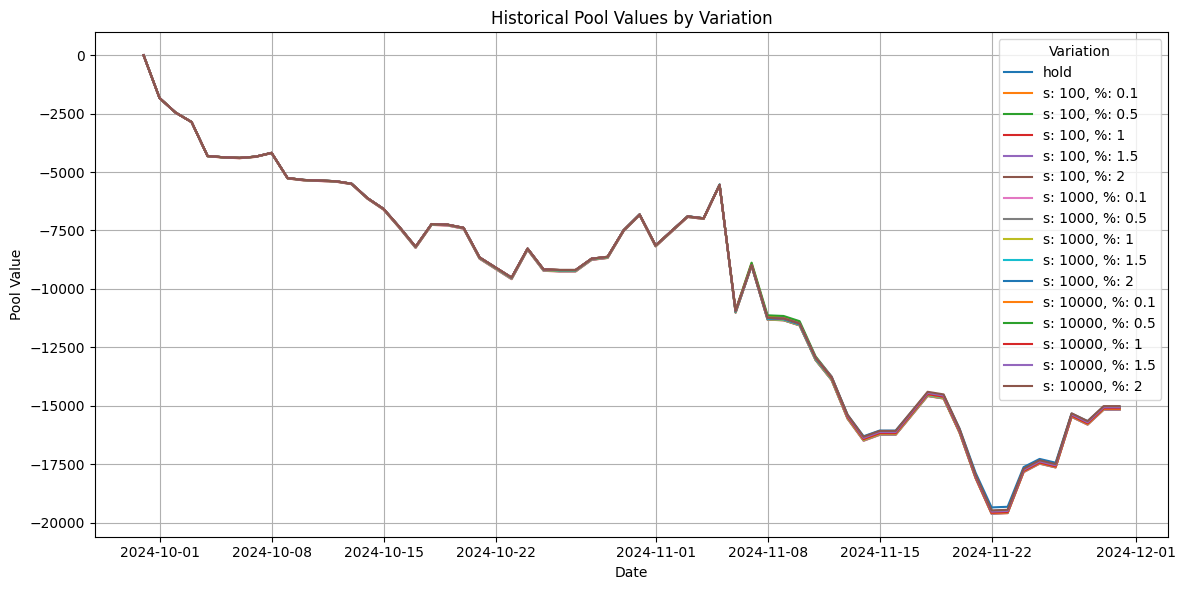

In [109]:
# If historical_values_df is already a DataFrame, use it directly
if isinstance(historical_values_df, pd.DataFrame):
    combined_df = historical_values_df
else:
    # If it's a dictionary, combine the series into a DataFrame
    combined_df = pd.DataFrame(historical_values_df)

# Ensure the index is properly aligned
combined_df.index = pd.to_datetime(combined_df.index)

# Display the unified DataFrame for the user
combined_df

# Plot the unified historical values for each variation
plt.figure(figsize=(12, 6))
for column in combined_df.columns:
    plt.plot(combined_df.index, combined_df[column], label=column)

# Customize the plot
plt.title("Historical Pool Values by Variation")
plt.xlabel("Date")
plt.ylabel("Pool Value")
plt.legend(title="Variation")
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()